In [2]:
print (__doc__)

Automatically created module for IPython interactive environment


### Faces recognition example using eigenfaces and SVMs : Multi-classification Problem

In [7]:
from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import metrics

In [8]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

#### The data we use are 1288 pictures. After transformed them into data, each picture will have 1850 dimensions, we use it to predict 7 people.

In [12]:
# Download the pictures and change them to array
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [13]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)


In [14]:
lfw_people.images.shape

(1288, 50, 37)

In [16]:
# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]


In [39]:
w

37

In [19]:
X.shape

(1288, 1850)

In [21]:
# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

In [27]:
target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')

In [28]:
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [56]:
###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_componentslist = [10, 15, 25, 50, 100, 250,300,350,450,500]

pcalist=[]
for i in n_componentslist:
    pca = PCA(n_components=i, whiten=True).fit(X_train)
    pcalist.append(pca)

eigenfaces=[]
for j in range(len(pcalist)):
    eigenface = pcalist[j].components_.reshape((n_componentslist[j], h, w))
    eigenfaces.append(eigenface)
    
#print ("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pcalist =[]
X_test_pcalist =[]

for j in range(len(pcalist)):
    X_train_pca = pcalist[j].transform(X_train)
    X_train_pcalist.append(X_train_pca)
    X_test_pca = pcalist[j].transform(X_test)
    X_test_pcalist.append(X_test_pca)

###############################################################################

In [57]:
# Train a SVM classification model with grid research to find best_estimator_

param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)


In [58]:
#F1scorelist=[]
clflist=[]
for i in range(len(X_train_pcalist)):
    clf_train = clf.fit(X_train_pcalist[i], y_train)
    clflist.append(clf_train)
    #y_pred=clf_train.predict(X_train_pcalist[i])
    #f1=metrics.f1_score(y_train, y_pred, average='weighted')  
    #F1scorelist.append(f1)
    #print ("ncomponet= %s, Best estimator found by grid search %s" % (str(n_componentslist[i]),str(clflist[i].best_estimator_)))


    #print clf.best_estimator_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr

#### Now we use best_estimator to fit the model and make prediction

In [59]:
y_predlist=[]
for i in range(len(n_componentslist)):
    clf_best=clflist[i].best_estimator_
    clf_best.fit(X_train_pcalist[i], y_train)
    y_pred =clf_best.predict(X_test_pcalist[i])
    y_predlist.append(y_pred)
    print (confusion_matrix(y_test, y_predlist[i], labels=range(n_classes)))
    print (classification_report(y_test,y_predlist[i],target_names=target_names))

[[ 4  5  2  0  0  1  1]
 [11 26  6  5  4  3  5]
 [ 4  3 13  3  3  1  0]
 [17 14  7 50 19 29 10]
 [ 0  0  7  4  6  5  3]
 [ 1  2  0  5  1  6  0]
 [ 1  4  7  0  3  8 13]]
                   precision    recall  f1-score   support

     Ariel Sharon       0.11      0.31      0.16        13
     Colin Powell       0.48      0.43      0.46        60
  Donald Rumsfeld       0.31      0.48      0.38        27
    George W Bush       0.75      0.34      0.47       146
Gerhard Schroeder       0.17      0.24      0.20        25
      Hugo Chavez       0.11      0.40      0.18        15
       Tony Blair       0.41      0.36      0.38        36

         accuracy                           0.37       322
        macro avg       0.33      0.37      0.32       322
     weighted avg       0.52      0.37      0.40       322

[[ 7  5  1  0  0  0  0]
 [14 34  6  3  1  0  2]
 [ 6  3 14  3  1  0  0]
 [14 16  9 82 12  5  8]
 [ 0  0  0  2 13  4  6]
 [ 0  1  0  1  4  8  1]
 [ 1  3  5  4  7  2 14]]
          

#### We can see that n_components=300 , the metrics are the best. So, more componements don't necessarily make better results. There're noises that we could throw away.

In [64]:
y_pred=y_predlist[-4]
eigenfaces_pred=eigenfaces[-4]

In [65]:
eigenfaces_pred.shape[0]

300

In [68]:
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=5, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


#### Let's visualize part of the eigenfaces and the prediction result. We did a quite great job!!

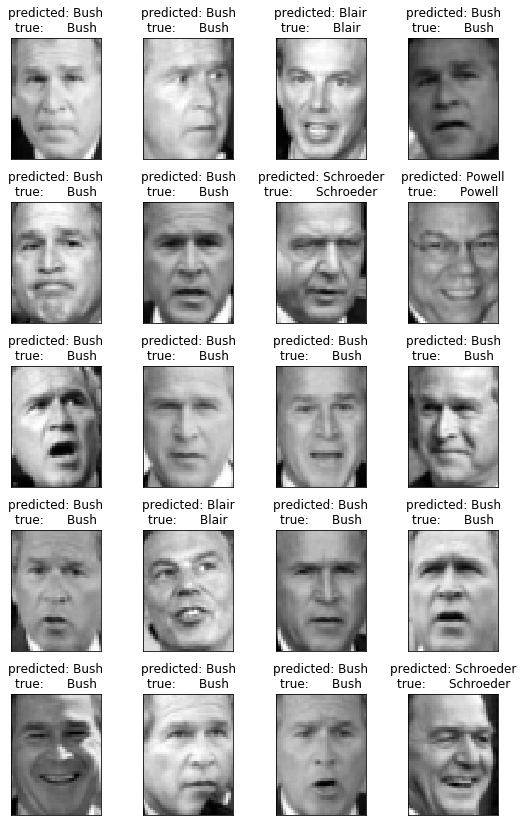

In [69]:
# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)



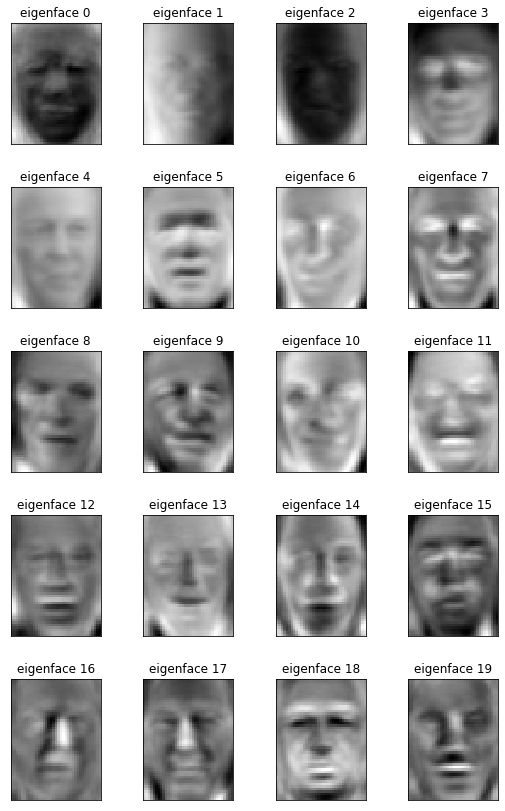

In [70]:
# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces_pred.shape[0])]
plot_gallery(eigenfaces_pred, eigenface_titles, h, w)

pl.show()